# DM - Classification [TASK 3]

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from wittgenstein import RIPPER
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from scikeras.wrappers import KerasClassifier

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in classification phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  11508 non-null  int64  
 1   statuses_count              11508 non-null  int64  
 2   bot                         11508 non-null  int64  
 3   tweets_num                  11508 non-null  int64  
 4   tweets_2020_num             11508 non-null  int64  
 5   likes_num                   11508 non-null  float64
 6   comments_num                11508 non-null  float64
 7   ratio_likes_x_tweets        11508 non-null  float64
 8   entropy                     11508 non-null  float64
 9   texts_mean_length           11508 non-null  float64
 10  texts_special_chars_length  11508 non-null  float64
 11  mean_pub_range              11508 non-null  float64
 12  mean_texts_similarity       11508 non-null  float64
dtypes: float64(8), int64(5)
memory 

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

In [5]:
predictions = {}

In [6]:
scaler = MinMaxScaler()
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [7]:
def gridsearch(train_set, train_label, model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4)
    return gs.fit(train_set, train_label)

In [8]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

In [9]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

### Decision tree

In [10]:
params = dict(
    max_depth=[5, 10, 20, 30, 40, 50],
    min_samples_leaf=[1, 2, 3, 4, 5]
)
dt = DecisionTreeClassifier(criterion='gini', splitter='best')
scores = gridsearch(train_set, train_label, dt, params)

scores

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [11]:
scores.best_params_

{'max_depth': 10, 'min_samples_leaf': 3}

In [12]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', **scores.best_params_)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3)

In [13]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

predictions["Decision tree"] = (train_pred_dt, test_pred_dt)

In [14]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.74      0.84      4313
         bot       0.81      0.98      0.89      4893

    accuracy                           0.87      9206
   macro avg       0.89      0.86      0.86      9206
weighted avg       0.88      0.87      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.91      0.71      0.79      1079
         bot       0.78      0.94      0.85      1223

    accuracy                           0.83      2302
   macro avg       0.85      0.82      0.82      2302
weighted avg       0.84      0.83      0.83      2302



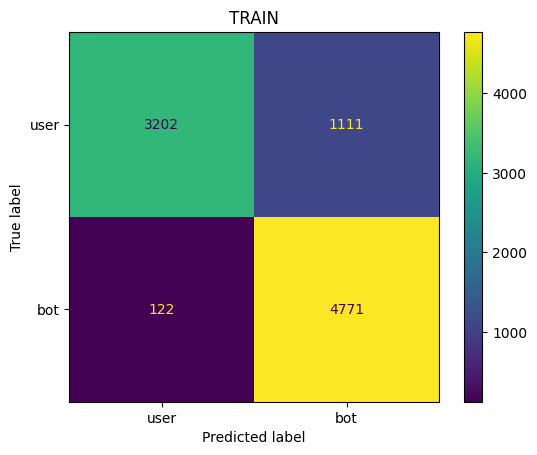

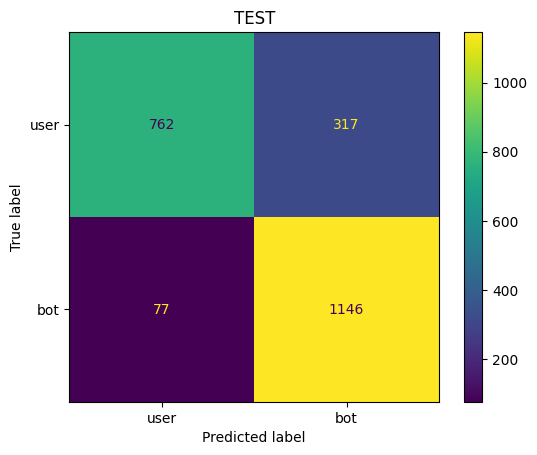

In [15]:
plot_cms(train_pred_dt, test_pred_dt)

### K-nearest neighbors

In [16]:
params = dict(n_neighbors=list(range(1, int(math.sqrt(train_set.shape[0])))))

knn = KNeighborsClassifier()
scores = gridsearch(train_set_scaled, train_label, knn, params)

scores

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [17]:
scores.best_params_

{'n_neighbors': 27}

In [18]:
knn = KNeighborsClassifier(**scores.best_params_)
knn = knn.fit(train_set_scaled, train_label)

In [19]:
train_pred_knn = knn.predict(train_set_scaled)
test_pred_knn = knn.predict(test_set_scaled)

predictions["KNN"] = (train_pred_knn, test_pred_knn)

In [20]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.90      0.54      0.68      4313
         bot       0.70      0.95      0.81      4893

    accuracy                           0.76      9206
   macro avg       0.80      0.74      0.74      9206
weighted avg       0.80      0.76      0.74      9206

TEST
              precision    recall  f1-score   support

        user       0.90      0.52      0.66      1079
         bot       0.69      0.95      0.80      1223

    accuracy                           0.75      2302
   macro avg       0.80      0.74      0.73      2302
weighted avg       0.79      0.75      0.74      2302



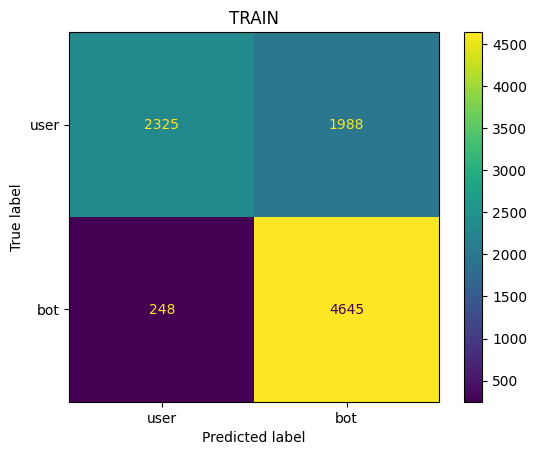

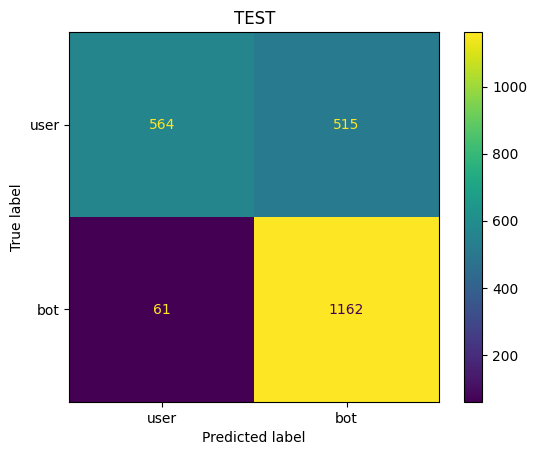

In [21]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

In [22]:
# RIPPER doesn't work with entropy rounded more than 4
train_set_rb = train_set.copy()
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

In [23]:
params = dict(
    k=[1, 2, 3],
    prune_size=[0.2, 0.33, 0.5]
)

rb = RIPPER(random_state=0)
scores = gridsearch(train_set_rb, train_label, rb, params)

scores

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed 

GridSearchCV(cv=4,
             estimator=<RIPPER(k=2, verbosity=0, n_discretize_bins=10, random_state=0, dl_allowance=64, prune_size=0.33, max_total_conds=None, max_rules=None, max_rule_conds=None)>,
             n_jobs=-1,
             param_grid={'k': [1, 2, 3], 'prune_size': [0.2, 0.33, 0.5]})

In [24]:
scores.best_params_

{'k': 1, 'prune_size': 0.5}

In [25]:
rb = RIPPER(random_state=0, **scores.best_params_)
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm.

In [26]:
rb.out_model()

[[entropy=<0.0001 ^ comments_num=>2.0 ^ mean_texts_similarity=0.0044-0.0079 ^ texts_special_chars_length=4.78-5.45] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ Unnamed:0=8009.5-9182.0 ^ texts_special_chars_length=>11.22] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ likes_num=47.0-224.5] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ ratio_likes_x_tweets=<0.016] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0 ^ texts_mean_length=69.97-74.56] V
[entropy=0.0001-0.0002 ^ texts_mean_length=62.98-65.43] V
[mean_texts_similarity=0.021-0.023 ^ texts_special_chars_length=5.45-5.84 ^ texts_mean_length=82.39-89.49] V
[entropy=0.0001-0.0002 ^ mean_texts_similarity=0.014-0.015] V
[entropy=0.0001-0.0002 ^ likes_num=4.0-6.0 ^ ratio_likes_x_tweets=0.05-0.067 ^ statuses_count=45.0-58.0] V
[statuses_count=35.0-45.0 ^ texts_mean_length=59.32-62.98] V
[entropy=0.0001-0.0002 ^ mean_pub_range=81116.29-96745.52 ^ ratio_likes_x_tweets=0.034-0.05 ^ statuse

In [27]:
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

predictions["Rule-based"] = (train_pred_rb, test_pred_rb)

In [28]:
report_scores(train_pred_rb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.76      0.68      0.71      4313
         bot       0.74      0.81      0.77      4893

    accuracy                           0.75      9206
   macro avg       0.75      0.74      0.74      9206
weighted avg       0.75      0.75      0.75      9206

TEST
              precision    recall  f1-score   support

        user       0.82      0.67      0.74      1079
         bot       0.75      0.87      0.80      1223

    accuracy                           0.78      2302
   macro avg       0.78      0.77      0.77      2302
weighted avg       0.78      0.78      0.77      2302



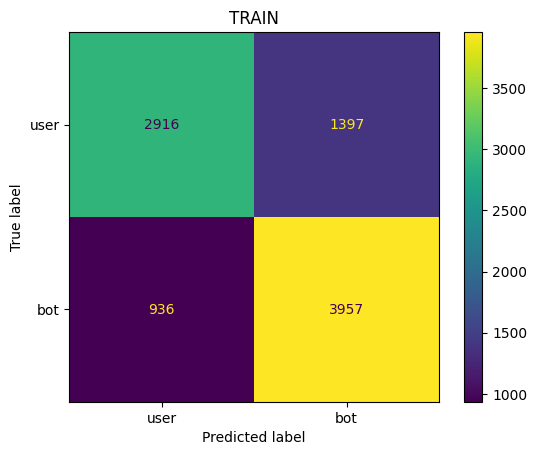

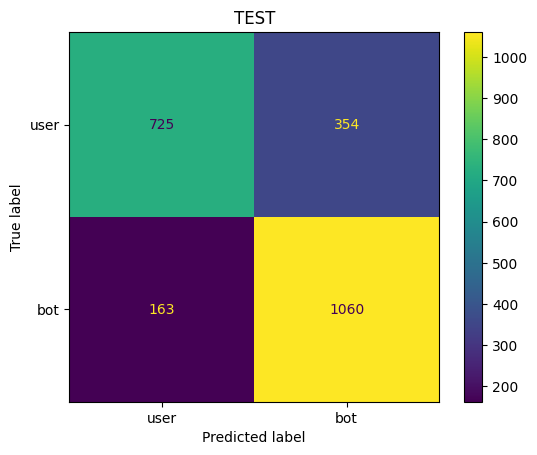

In [29]:
plot_cms(train_pred_rb, test_pred_rb)

### Naive Bayes

In [30]:
nb = GaussianNB()
nb.fit(train_set, train_label)

GaussianNB()

In [31]:
train_pred_nb = nb.predict(train_set)
test_pred_nb = nb.predict(test_set)

predictions["Naive Bayes"] = (train_pred_nb, test_pred_nb)

In [32]:
report_scores(train_pred_nb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.70      0.27      0.39      4313
         bot       0.58      0.90      0.71      4893

    accuracy                           0.60      9206
   macro avg       0.64      0.58      0.55      9206
weighted avg       0.64      0.60      0.56      9206

TEST
              precision    recall  f1-score   support

        user       0.82      0.67      0.74      1079
         bot       0.75      0.87      0.80      1223

    accuracy                           0.78      2302
   macro avg       0.78      0.77      0.77      2302
weighted avg       0.78      0.78      0.77      2302



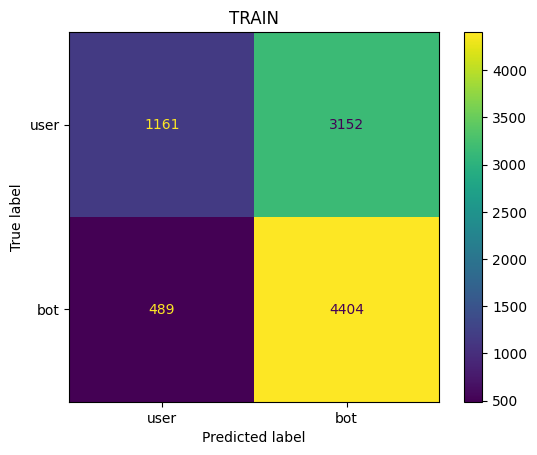

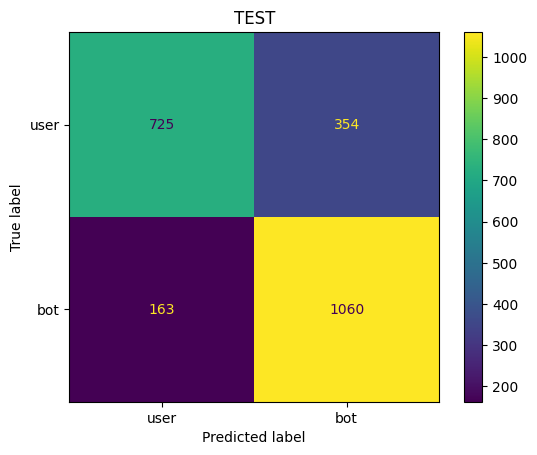

In [33]:
plot_cms(train_pred_nb, test_pred_rb)

### Ensemble methods

#### AdaBoost

In [34]:
params = dict(
    n_estimators=list(range(10, 201, 10)),
    learning_rate=[0.1, 0.3, 0.05, 0.01]
)

boost = AdaBoostClassifier()
scores = gridsearch(train_set, train_label, boost, params)

scores

GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.05, 0.01],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [35]:
scores.best_params_

{'learning_rate': 0.3, 'n_estimators': 200}

In [36]:
boost = AdaBoostClassifier(**scores.best_params_)
boost.fit(train_set, train_label)

AdaBoostClassifier(learning_rate=0.3, n_estimators=200)

In [37]:
train_pred_boost = boost.predict(train_set)
test_pred_boost = boost.predict(test_set)

predictions["AdaBoost"] = (train_pred_boost, test_pred_boost)

In [38]:
report_scores(train_pred_boost, test_pred_boost)

TRAIN
              precision    recall  f1-score   support

        user       0.92      0.69      0.79      4313
         bot       0.78      0.95      0.85      4893

    accuracy                           0.83      9206
   macro avg       0.85      0.82      0.82      9206
weighted avg       0.84      0.83      0.82      9206

TEST
              precision    recall  f1-score   support

        user       0.91      0.70      0.79      1079
         bot       0.78      0.94      0.85      1223

    accuracy                           0.83      2302
   macro avg       0.85      0.82      0.82      2302
weighted avg       0.84      0.83      0.83      2302



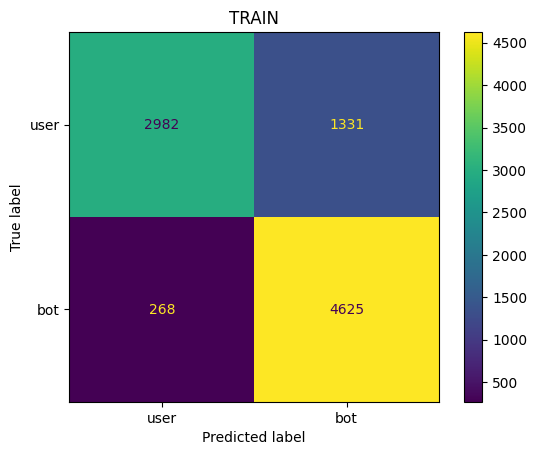

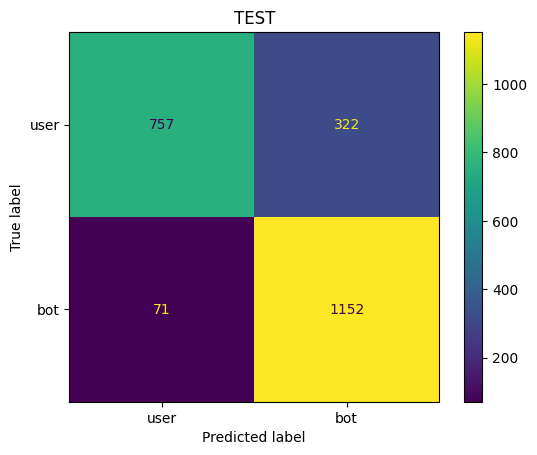

In [39]:
plot_cms(train_pred_boost, test_pred_boost)

#### Random forest

In [40]:
params = dict(n_estimators=list(range(10, 201, 10)))

rf = RandomForestClassifier()
scores = gridsearch(train_set, train_label, rf, params)

scores

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [41]:
scores.best_params_

{'n_estimators': 190}

In [42]:
rf = RandomForestClassifier(**scores.best_params_)
rf.fit(train_set, train_label)

RandomForestClassifier(n_estimators=190)

In [43]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

predictions["Random forest"] = (train_pred_rf, test_pred_rf)

In [44]:
report_scores(train_pred_rf, test_pred_rf)

TRAIN
              precision    recall  f1-score   support

        user       1.00      1.00      1.00      4313
         bot       1.00      1.00      1.00      4893

    accuracy                           1.00      9206
   macro avg       1.00      1.00      1.00      9206
weighted avg       1.00      1.00      1.00      9206

TEST
              precision    recall  f1-score   support

        user       0.93      0.72      0.81      1079
         bot       0.79      0.95      0.86      1223

    accuracy                           0.84      2302
   macro avg       0.86      0.83      0.84      2302
weighted avg       0.86      0.84      0.84      2302



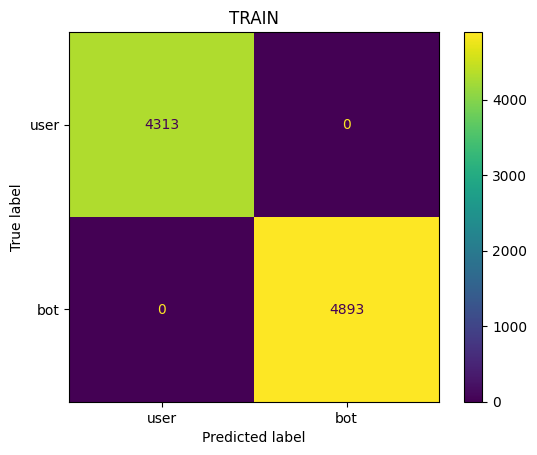

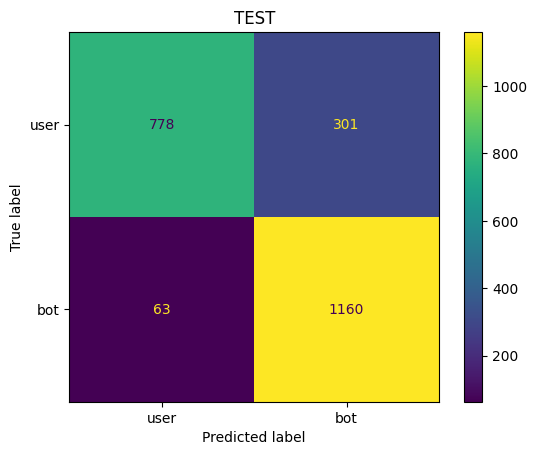

In [45]:
plot_cms(train_pred_rf, test_pred_rf)

### SVM

In [46]:
params = dict(
    kernel=['rbf', 'sigmoid'],
    C=[1, 2, 5]
)

svm = SVC()
scores = gridsearch(train_set_scaled, train_label, svm, params)

scores

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 5], 'kernel': ['rbf', 'sigmoid']})

In [47]:
scores.best_params_

{'C': 5, 'kernel': 'rbf'}

In [48]:
svm = SVC(**scores.best_params_)
svm.fit(train_set_scaled, train_label)

SVC(C=5)

In [49]:
train_pred_svm = svm.predict(train_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)

predictions["SVM"] = (train_pred_svm, test_pred_svm)

In [50]:
report_scores(train_pred_svm, test_pred_svm)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.50      0.65      4313
         bot       0.69      0.98      0.81      4893

    accuracy                           0.75      9206
   macro avg       0.82      0.74      0.73      9206
weighted avg       0.81      0.75      0.74      9206

TEST
              precision    recall  f1-score   support

        user       0.95      0.49      0.64      1079
         bot       0.68      0.98      0.80      1223

    accuracy                           0.75      2302
   macro avg       0.82      0.73      0.72      2302
weighted avg       0.81      0.75      0.73      2302



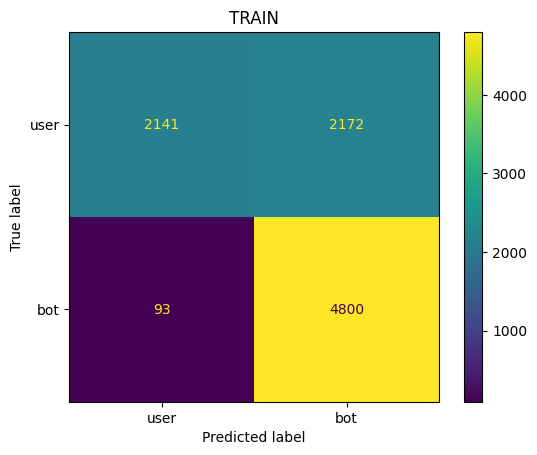

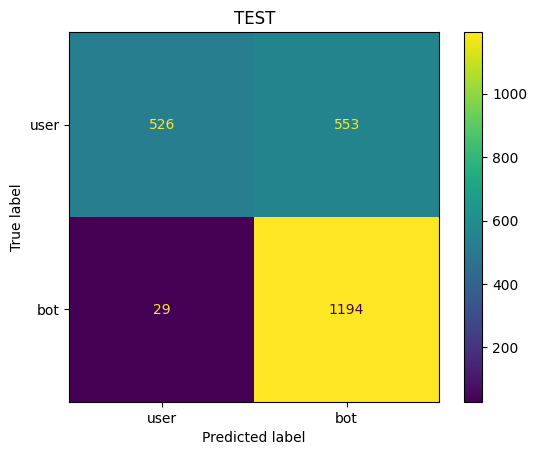

In [51]:
plot_cms(train_pred_svm, test_pred_svm)

### Neural network

In [52]:
x_train_nn = np.reshape(train_set_scaled, (-1, 1, train_set.shape[1]))
x_test_nn = np.reshape(test_set_scaled, (-1, 1, test_set.shape[1]))
y_train_nn = np.asarray(train_label).reshape((-1,1))
y_test_nn = np.asarray(test_label).reshape((-1,1))

In [53]:
def create_nn(hidden_units, hidden_activation):
    nn = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(1, train_set.shape[1])),
            keras.layers.Dense(hidden_units, activation=hidden_activation),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    nn.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])

    return nn

In [54]:
params = dict(
    model__hidden_units=[32, 64, 128, 516, 1024, 2048],
    model__hidden_activation=['sigmoid', 'relu', 'tanh']
)

nn = KerasClassifier(model=create_nn, epochs = 100, batch_size = 516)
scores = gridsearch(x_train_nn, y_train_nn, nn, params)

scores

2023-01-02 02:34:58,696 - concurrent.futures - ERROR - exception calling callback for <Future at 0x28de69600 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/geremiapo

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}

In [ ]:
scores.best_params_

In [ ]:
best_params = {k.replace('model__', ''): v for k, v in scores.best_params_.items()}

nn = create_nn(**best_params)
nn.fit(x_train_nn, y_train_nn, epochs = 100, batch_size = 516)

In [ ]:
train_pred_nn = (nn.predict(x_train_nn) > 0.5).astype("int32")
test_pred_nn = (nn.predict(x_test_nn) > 0.5).astype("int32")

predictions["Neural network"] = (train_pred_nn, test_pred_nn)

In [ ]:
report_scores(train_pred_nn, test_pred_nn)

In [ ]:
plot_cms(train_pred_nn, test_pred_nn)

## Comparisons

In [ ]:
def plot_roc(roc_type="test"):
    plt.figure(0).clf()
    is_test = roc_type == "test"
    index = 1 if is_test else 0

    for key, value in predictions.items():
        pred = value[index]
        label = test_label if is_test else train_label
        fpr, tpr, thresh = metrics.roc_curve(label, pred)
        auc = metrics.roc_auc_score(label, pred)
        plt.plot(fpr,tpr,label=f"{key}, auc="+str(round(auc, 2)))
        plt.title("Test" if is_test else "Train")

    plt.legend(loc=0)

In [ ]:
plot_roc("train")

In [ ]:
plot_roc("test")